In [ ]:
!pip install optuna

# Данные
import pandas as pd
import numpy as np

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Предобработка и анализ
from scipy.stats import mannwhitneyu

# Моделирование и оценка
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
import optuna

# 1. Предобработка данных

Загрузка и предварительное ознакомление с данными

In [ ]:
df = pd.read_csv('mouse_task_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16644 entries, 0 to 16643
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  16644 non-null  int64  
 1   coords      16644 non-null  object 
 2   target      90 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 390.2+ KB


In [ ]:
df.set_index('Unnamed: 0', inplace=True)  # Назначим индексы из таблицы
df['target'] = df['target'].fillna(0)  # Преобразуем метки таргета из nan в 0
df['target'] = df['target'].astype('int64')  # Меняем dtype таргета с float64 на int64

In [ ]:
# Удаляем дубликаты
rows = df.shape[0]
df.drop_duplicates(inplace=True)
print(f'Удалено {rows - df.shape[0]} дубликатов')

Удалено 151 дубликатов


In [ ]:
df.head(2)

,coords,target
Unnamed: 0,,
0,"[{'x': [251, 246, 233, 83, 14, 19, 22, 39, 39,...",1
1,"[{'x': [310, 269, 179, 67, 109, 156, 202, 251,...",1


Парсинг coords

In [ ]:
# В списке coords, может быть любое кол-во словарей с {x: [], y: [], t: []}.
# В условии сказано, что это данные об одной сесиии. Поэтому каждый новый словарь,
# вероятно, соответсвует различным действиям на сайте. Для удобства преобразуем coords
# в отдельные столбцы x, y, t.

In [ ]:
def extract_xyt_lists(raw_list):
    """
    Извлекает координаты 'x', 'y', 't' из списка словарей.

    Функция принимает список словарей, где каждый словарь содержит ключи
    'x', 'y', 't', соответствующие спискам числовых значений.
    Возвращает три отдельных списка списков: один для x-координат, один для
    y-координат и один для временных меток, сохраняя порядок исходных записей.
    """
    x, y, t = [], [], []

    for raw_dict in raw_list:
        # Берём подсписки как есть, без объединения
        x.append(raw_dict.get('x', []))
        y.append(raw_dict.get('y', []))
        t.append(raw_dict.get('t', []))

    return x, y, t

df['coords'] = df['coords'].map(eval)  # Приведем к словарю
extracted = df['coords'].map(extract_xyt_lists) # Применяем функцию разделения на списки
df['x'] = extracted.map(lambda val: val[0])
df['y'] = extracted.map(lambda val: val[1])
df['t'] = extracted.map(lambda val: val[2])


# Почистим память
del extracted
df.drop(columns=['coords'], inplace=True)

In [ ]:
df.head(2)

,target,x,y,t
Unnamed: 0,,,,
0,1,"[[251, 246, 233, 83, 14, 19, 22, 39, 39, 39, 4...","[[577, 571, 543, 944, 1187, 1204, 1213, 1257, ...","[[1693841989296, 1693841989329, 1693841989453,..."
1,1,"[[310, 269, 179, 67, 109, 156, 202, 251, 274, ...","[[199, 142, 15, 232, 341, 450, 552, 645, 684, ...","[[1680773442320, 1680773442323, 1680773442329,..."


# 2.EDA

Отношение классов

In [ ]:
df.groupby('target')['x'].count() / df.shape[0] * 100  # Наблюдаем сильный дисбаланс классов

,x
target,
0,99.454314
1,0.545686


Карта активности для каждого класса

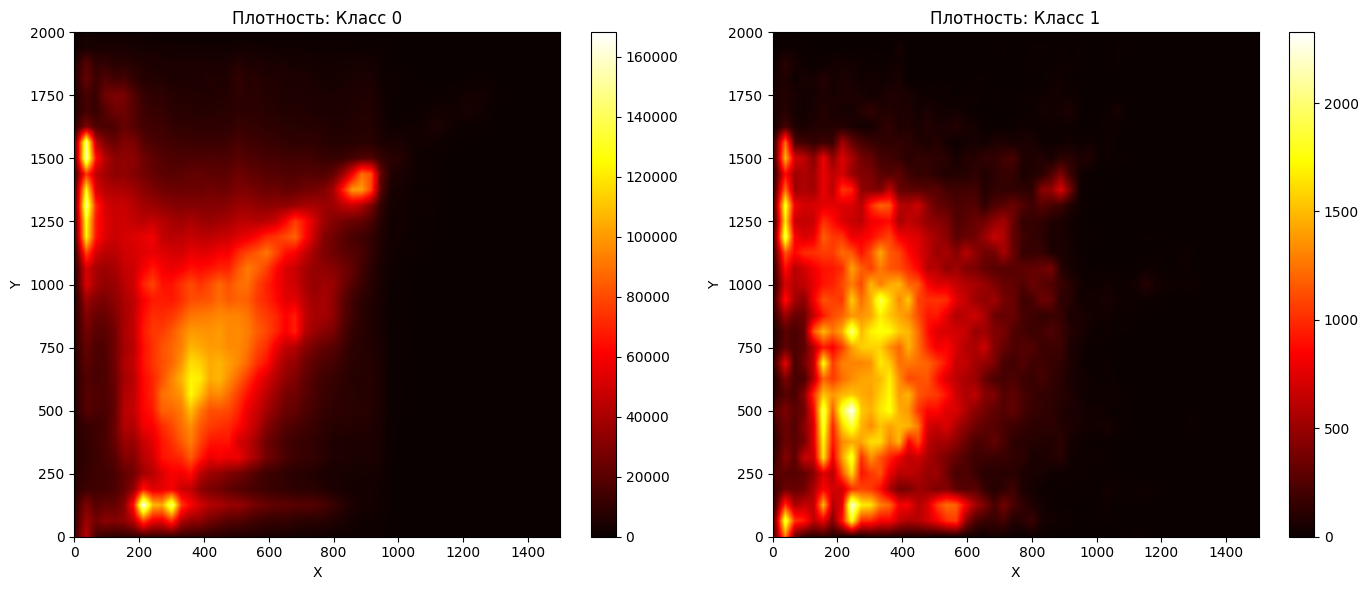

In [ ]:
# Собираем все точки
points_0 = {'x': [], 'y': []}
points_1 = {'x': [], 'y': []}

for _, row in df.iterrows():
    label = row['target']
    target = points_0 if label == 0 else points_1

    # Распаковываем списки списков координат
    for x_sub, y_sub in zip(row['x'], row['y']):
        target['x'].extend(x_sub)
        target['y'].extend(y_sub)

# Преобразуем в массивы
x0, y0 = np.array(points_0['x']), np.array(points_0['y'])
x1, y1 = np.array(points_1['x']), np.array(points_1['y'])

# Определяем общий диапазон
all_x = np.concatenate([x0, x1])
all_y = np.concatenate([y0, y1])
range_x = [all_x.min(), all_x.max()]
range_y = [all_y.min(), all_y.max()]

# Строим heatmap
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, (x, y, label, ax) in enumerate(zip([x0, x1], [y0, y1], ['Класс 0', 'Класс 1'], axes)):
    if len(x) == 0:
        ax.set_title(f'{label} — нет данных')
        continue

    heatmap, xedges, yedges = np.histogram2d(x, y, bins=100, range=[range_x, range_y])
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    im = ax.imshow(
        heatmap.T,
        extent=extent,
        origin='lower',
        cmap='hot',
        interpolation='bilinear',
        aspect='auto'
    )
    ax.set_title(f'Плотность: {label}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim(0, 1500)
    ax.set_ylim(0, 2000)
    plt.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()

In [ ]:
# На хит-мапах наблюдается чёткое различие в паттернах перемещения курсора между классами.
# Для класса 0 характерно наличие выраженных "горячих" зон, соответствующих
# ключевым точкам взаимодействия. При этом плотность распределения вокруг этих
# точек имеет размытую, диффузную структуру, что типично для естественного поведения
# человека: движения сопровождаются небольшими колебаниями, неточностями.

# В отличие от этого, класс 1 демонстрирует более дискретное распределение:
# курсор преимущественно появляется в отдельных, чётко ограниченных точках или вдоль
# прямолинейных траекторий. Такой паттерн указывает на алгоритмическое
# поведение - например, прямые переходы между координатами без промежуточных
# движений или перемещения вдоль одной оси.

Генерация признаков для EDA

In [ ]:
def compute_all_features(row):
    """
    Вычисляет агрегированные признаки на основе координат и временных меток.

    Args:
        row (pd.Series): Строка датафрейма с колонками 'x', 'y', 't'.
            Каждая колонка содержит список списков чисел:
                - x: [[x1_1, x1_2, ...], [x2_1, ...], ...]
                - y: аналогично
                - t: аналогично

    Returns:
        pd.Series: Серия с вычисленными признаками:
            - num_subsessions: количество подсессий
            - num_points: общее число точек
            - mean_points_subsession: среднее число точек на подсессию
            - total_time: суммарная длительность всей сессии
            - mean_time_subsession: средняя длительность подсессии
            - max_x_speed, max_y_speed, max_speed: максимальные компоненты скорости
            - mean_speed, std_speed: средняя и стандартное отклонение модуля скорости
            - straightness: средняя прямолинейность траекторий
    """
    x_lists, y_lists, t_lists = row['x'], row['y'], row['t']

    # Вычисляем базовые признаки
    num_subsessions = len(x_lists)
    num_points = sum(len(x_sub) for x_sub in x_lists)
    mean_points_subsession = num_points / num_subsessions

    # Временные признаки
    total_time = 0.0
    for t_sub in t_lists:
        total_time += t_sub[-1] - t_sub[0]
    mean_time_subsession = total_time / num_subsessions

    # Признаки скорости и straightness
    all_total_speeds = []  # все значения модуля скорости для mean и std
    max_x_speed, max_y_speed, max_total_speed = 0, 0, 0
    straightness_vals = []  # straightness для каждой подсессии

    # Обрабатываем каждую подсессию отдельно
    for x_sub, y_sub, t_sub in zip(x_lists, y_lists, t_lists):
        if len(x_sub) < 2:  # недостаточно точек для вычисления скорости
            continue

        x, y, t = np.array(x_sub), np.array(y_sub), np.array(t_sub)
        dx, dy, dt = np.diff(x), np.diff(y), np.diff(t)

        # Пропускаем нулевые временные интервалы
        valid = dt != 0
        if not np.any(valid):
            continue
        dx, dy, dt = dx[valid], dy[valid], dt[valid]

        vx = dx / dt
        vy = dy / dt
        v_total = np.sqrt(vx**2 + vy**2)

        # Агрегируем скорости
        all_total_speeds.extend(v_total.tolist())
        max_x_speed = max(max_x_speed, np.max(np.abs(vx)))
        max_y_speed = max(max_y_speed, np.max(np.abs(vy)))
        max_total_speed = max(max_total_speed, np.max(v_total))

        # Straightness
        path_length = np.sum(np.sqrt(dx**2 + dy**2))
        displacement = np.sqrt((x[-1] - x[0])**2 + (y[-1] - y[0])**2)
        if path_length > 0:
            straightness_vals.append(displacement / path_length)
        else:
            straightness_vals.append(0.0)

    # Финальные агрегаты по скоростям
    if all_total_speeds:
        mean_speed = np.mean(all_total_speeds)
        std_speed = np.std(all_total_speeds)
    else:
        mean_speed = std_speed = 0.0

    straightness = np.mean(straightness_vals)

    return pd.Series({
        'num_subsessions': num_subsessions,
        'num_points': num_points,
        'mean_points_subsession': mean_points_subsession,
        'total_time': total_time,
        'mean_time_subsession': mean_time_subsession,
        'max_x_speed': max_x_speed,
        'max_y_speed': max_y_speed,
        'max_speed': max_total_speed,
        'mean_speed': mean_speed,
        'std_speed': std_speed,
        'straightness': straightness
    })


feature_df = df.apply(compute_all_features, axis=1)
df = pd.concat([df, feature_df], axis=1)  # Объединяем с исходным df
df.drop(columns=['x', 'y', 't'], inplace=True)  # Удалим временное представление

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16493 entries, 0 to 7124
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   target                  16493 non-null  int64  
 1   num_subsessions         16493 non-null  float64
 2   num_points              16493 non-null  float64
 3   mean_points_subsession  16493 non-null  float64
 4   total_time              16493 non-null  float64
 5   mean_time_subsession    16493 non-null  float64
 6   max_x_speed             16493 non-null  float64
 7   max_y_speed             16493 non-null  float64
 8   max_speed               16493 non-null  float64
 9   mean_speed              16493 non-null  float64
 10  std_speed               16493 non-null  float64
 11  straightness            16493 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 1.6 MB


In [ ]:
# Преобразуем целочисленные признаки в инты
df[['num_subsessions', 'num_points', 'total_time']] = df[['num_subsessions', 'num_points', 'total_time']].astype('int64')

Проверка стат. различий подвыборок для класса 0 и 1 по каждому признаку

In [ ]:
def get_feature_importance(df, target_col='target'):
    """
    Оценивает статистическую значимость признаков с помощью Mann-Whitney U test.

    Для каждого признака сравнивает распределения между классами 0 и 1.
    Возвращает p-значения, отсортированные по возрастанию.
    """
    features = [col for col in df.columns if col != target_col]
    results = []

    for col in features:
        class_0 = df[df[target_col] == 0][col]
        class_1 = df[df[target_col] == 1][col]

        # Сравниваем распределения признака между классами
        _, pval = mannwhitneyu(class_0, class_1, alternative='two-sided')
        results.append({
            'feature': col,
            'p_value': pval,
            })

    return pd.DataFrame(results).sort_values('p_value')


importance_df = get_feature_importance(df)
importance_df.T

,5,6,7,9,0,1,8,3,2,10,4
feature,max_x_speed,max_y_speed,max_speed,std_speed,num_subsessions,num_points,mean_speed,total_time,mean_points_subsession,straightness,mean_time_subsession
p_value,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000024,0.002988,0.842977


In [ ]:
# Для признака mean_time_subsession тест показал, слишком высокий p_value.
# В выборках нет различий, поэтому данный признак малоинформативен.
df.drop(columns=['mean_time_subsession'], inplace=True)

Анализ распределений по гистограммам

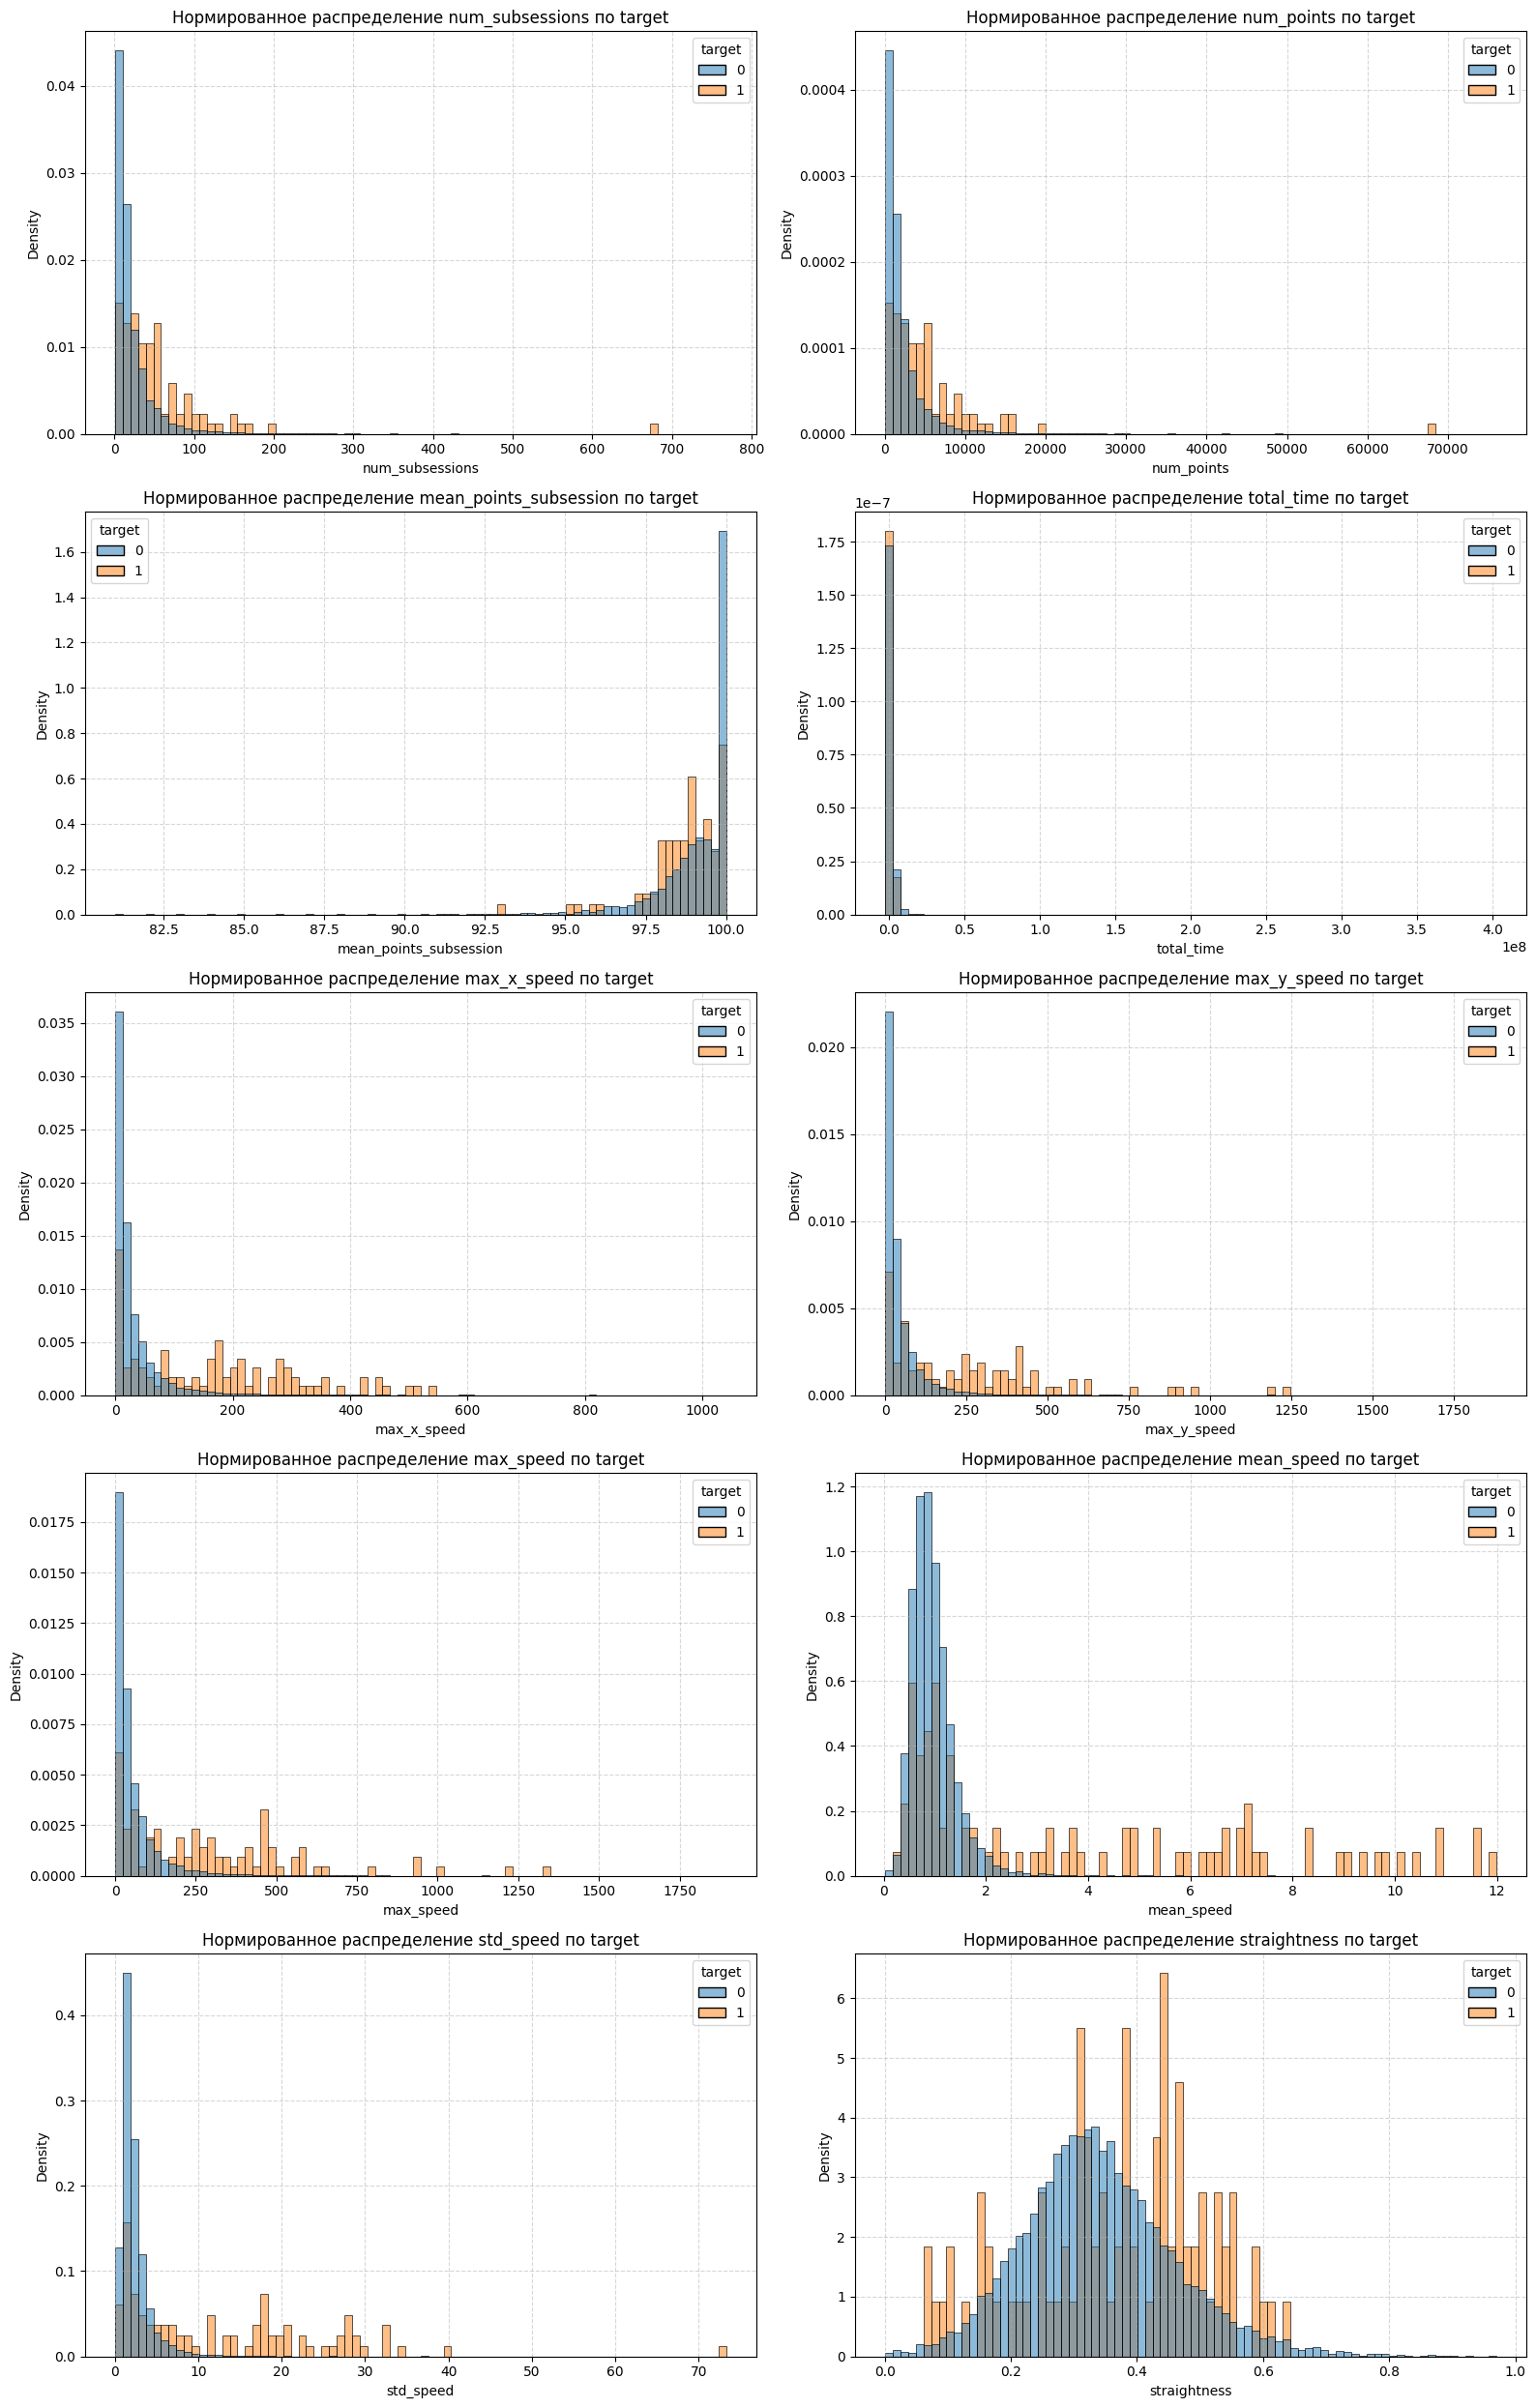

In [ ]:
feature_columns = df.drop(columns=['target']).columns.tolist()

n_cols = 2  # по 2 графика в строке
n_rows = (len(feature_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
axes = axes.flatten()

# Строим гистограммы
for i, col in enumerate(feature_columns):
    sns.histplot(
        data=df,
        x=col,
        hue='target',
        bins=80,
        stat='density',
        common_norm=False,
        alpha=0.5,
        ax=axes[i]
    )
    axes[i].set_title(f'Нормированное распределение {col} по target')
    axes[i].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [ ]:
#   1. Признаки num_subcessions и num_points визуально схожи, что логично: чем больше подсессий, тем больше точек траектории.
# Оба показывают, что у фрода большее кол-во подсессий и соответсвенно большее кол-во зафиксированных точек.
#   2. Однако при этом среднее количество точек на одну подсессию (mean_points_subsession)
# у фрода ниже, что может указывать на более короткие и/или менее детализированные подсессии - возможно,
# связанные с автоматизированным поведением.
#   3. Общее время сесиии для фрода и нормы визуально схожи. что говорит о том, что
# мошенники стремятся имитировать естественную длительность взаимодействия.
#   4. Анализ признаков скорости показывает, что фрод пытается имитировать распределение
# скоростей легитимных пользователей, однако в его распределении наблюдается большее
# количество экстремально высоких значений скорости, что может быть признаком неестественного, рывкового перемещения курсора
#   5. Наиболее информативным оказывается признак прямолинейности (straightness).
# У легитимных пользователей его распределение близко к нормальному, что отражает естественные,
# слегка извилистые траектории движения мыши. У фрода наблюдаются ярко выраженные
# пики в определённых диапазонах значений, что, вероятно, связано с использованием
# скриптов, генерирующих траектории с фиксированной или ограниченной изменчивостью.

Проверка на мультиколлинеарность

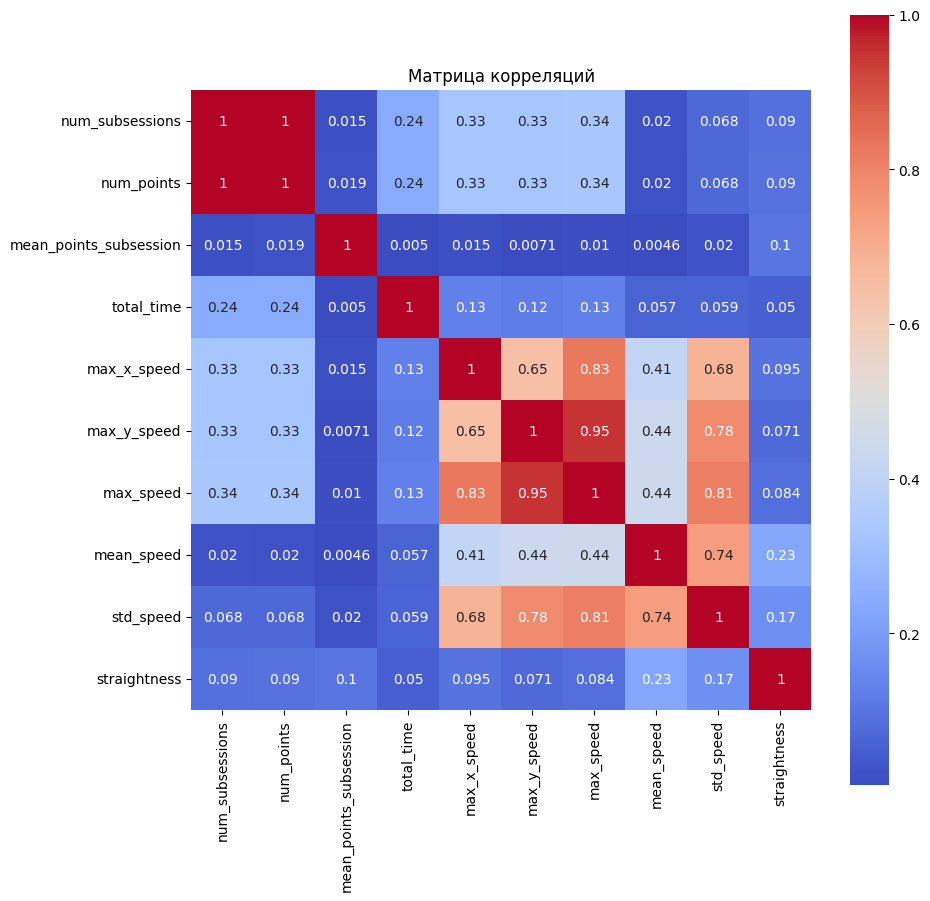

In [ ]:
corr_matrix = df.drop(columns=['target']).corr().abs()

# Строим тепловую карту
plt.figure(figsize=(10, 10))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    square=True,
    annot=True
)
plt.title('Матрица корреляций')
plt.show()

In [ ]:
# Удаляем 'num_points' т.к. идентичен 'num_subcessions', 'max_y_speed' имеет высокую
# корреляцию с 'max_speed', но 'max_speed' более информативен.
df.drop(columns=['num_subsessions', 'max_y_speed'], inplace=True)

Выбросы

In [ ]:
def count_outliers_by_class(series, target, class_label):
    """Считает число выбросов в признаке для заданного класса по правилу IQR."""

    subset = series[target == class_label]
    if len(subset) < 2:
        return 0
    Q1 = subset.quantile(0.25)
    Q3 = subset.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return ((subset < lower) | (subset > upper)).sum()


# Список признаков
features = df.drop(columns=['target']).columns.tolist()
# Таблица для хранения количества выбросов
outliers = pd.DataFrame(index=(0, 1), columns=features)

# Считаем выбросы для каждого признака и каждого класса
for col in features:
    outliers.loc[0, col] = count_outliers_by_class(df[col], df['target'], 0)
    outliers.loc[1, col] = count_outliers_by_class(df[col], df['target'], 1)

# Нормализуем на размер каждого класса
group_sizes = df.groupby('target').size()
outliers.iloc[0] = outliers.iloc[0] / group_sizes[0]
outliers.iloc[1] = outliers.iloc[1] / group_sizes[1]
outliers * 100  # Результат в процентах

,num_points,mean_points_subsession,total_time,max_x_speed,max_speed,mean_speed,std_speed,straightness
0,7.882704,4.621106,12.88179,9.187344,8.388709,3.523746,6.821923,1.999634
1,6.666667,5.555556,3.333333,0.0,2.222222,0.0,1.111111,0.0


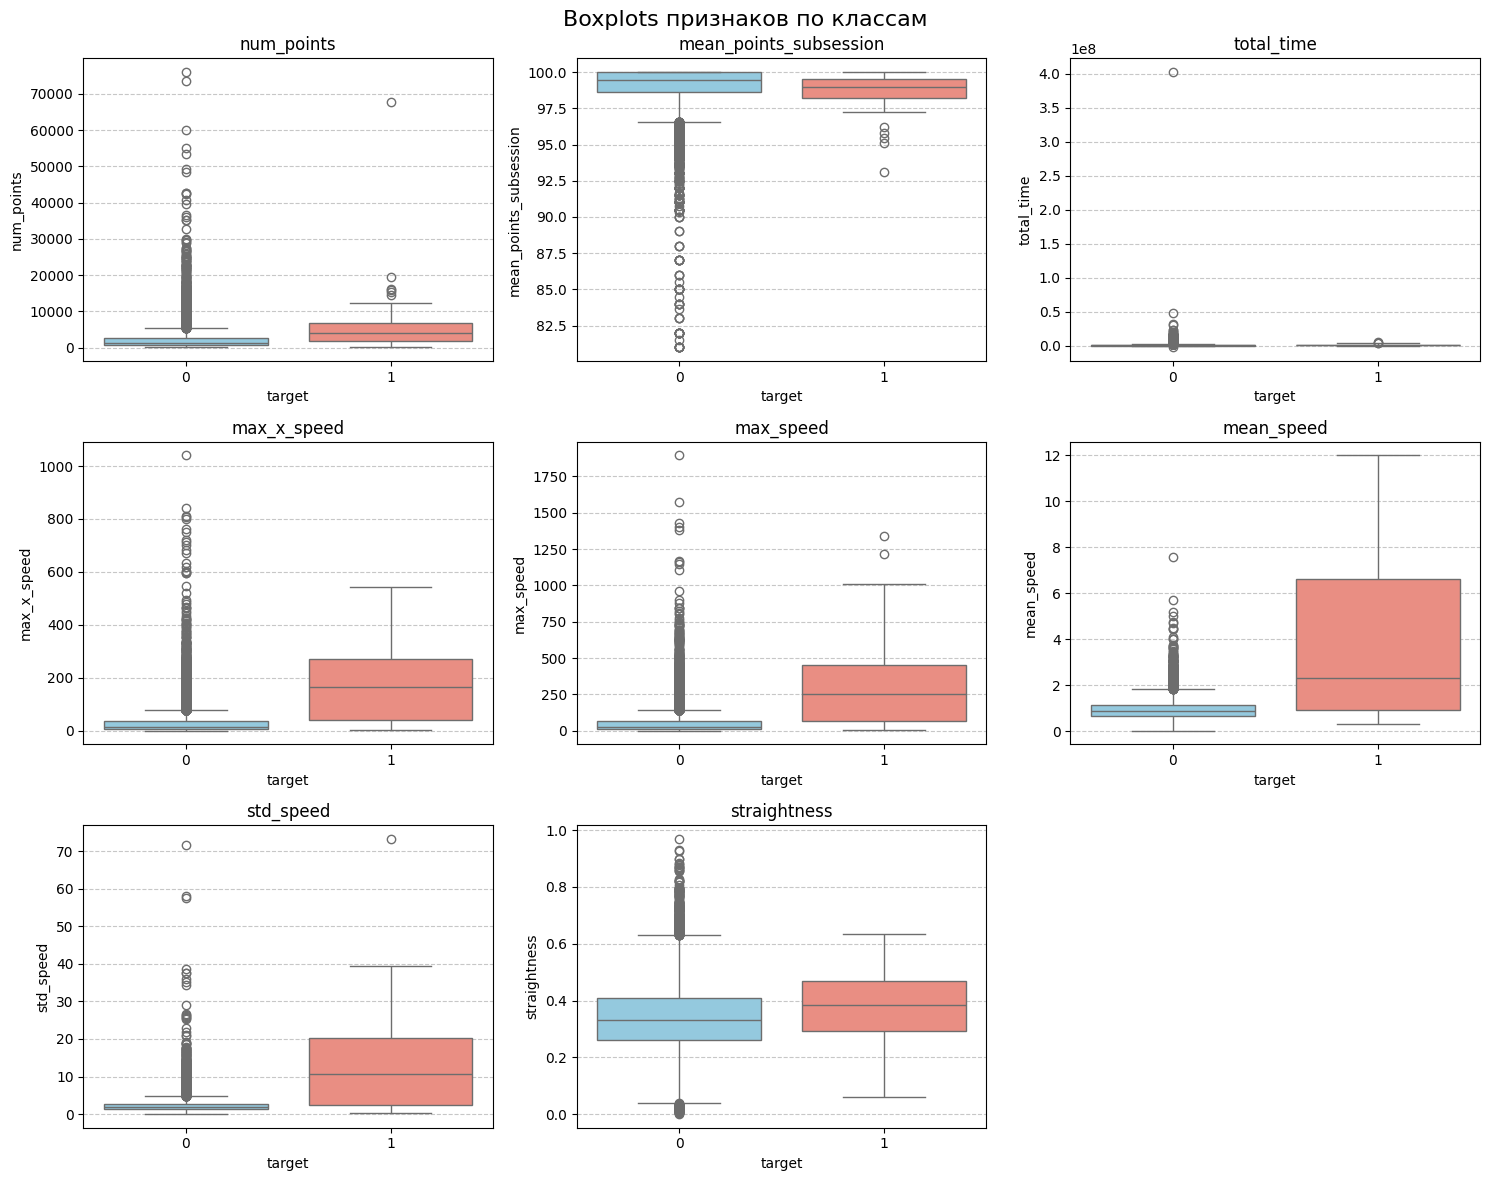

In [ ]:
# Определяем количество строк и столбцов для сетки
n_features = len(features)
n_cols = 3  # количество графиков в строке
n_rows = (n_features + n_cols) // n_cols  # количество строк для графиков

plt.figure(figsize=(5 * n_cols, 4 * n_rows))
plt.suptitle('Boxplots признаков по классам', fontsize=16)

for i, col in enumerate(features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(
        data=df,
        x='target',
        y=col,
        hue='target',
        palette={0: 'skyblue', 1: 'salmon'},
        legend=False
    )
    plt.title(f'{col}')
    plt.xlabel('target')
    plt.ylabel(col)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
# Достаточно много выбросов через 1.5IQR для нефрода, вероятно это
# малопредставленные группы ольззователей. Выбросы не убираем кроме total_time > 10 ** 8.
rows = df.shape[0]
df.drop(index=df[df['total_time'] > 10 ** 8].index, inplace=True)
print(f'Удалено {rows - df.shape[0]} строк')

Удалено 2 строк


# 3. Генерация новых признаков

In [ ]:
# Отношение max_speed к mean_speed: резкие рывки - подозрительно
df['speed_burst'] = df['max_speed'] / df['mean_speed']

# Очень мало точек за большое время или много точек за малое время - подозрительно
df['low_activity_ratio'] = df['num_points'] / df['total_time']

# Можно сгенерировать значительно больше признаков, однако целесообразно
# оценивать их полезность по реальному приросту качества модели,
# чтобы избежать переобучения и излишнего усложнения

# 4. Обучение модели и подбор гиперпараметров

Поиск параметров модели

In [ ]:
def objective(trial):
  """Целевая функция для Optuna: оптимизирует гиперпараметры XGBoost по средней precision (CV)"""

  # Рассчитываем вес для балансировки классов
  neg, pos = df['target'].value_counts()[0], df['target'].value_counts()[1]
  scale_pos_weight = neg / pos

  # Гиперпараметры модели
  params = {'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'scale_pos_weight': scale_pos_weight,
            'random_state': 0,
            'n_estimators': trial.suggest_int('n_estimators', 30, 3000),
            'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_float('gamma', 0, 10),
            }

  # Обучаем и оцениваем через кросс-валидацию
  model = xgb.XGBClassifier(**params)
  precisions = cross_val_score(model, X_train, y_train, cv=3, scoring='precision')
  return precisions.mean()


# Подготовка данных
X = df.drop(columns=['target'])
y = df['target']

# train/test split с сохранением пропорций классов
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

# Запуск оптимизации гиперпараметров
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, show_progress_bar=True)

print("Лучшие параметры:", study.best_params)
print("Лучший precision:", study.best_value)

[I 2025-10-05 20:51:28,180] A new study created in memory with name: no-name-6f61e044-10d1-440a-abb9-9fb78aa9ad6c


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-10-05 20:52:12,116] Trial 0 finished with value: 0.5344017094017094 and parameters: {'n_estimators': 1669, 'eta': 0.015448329738145248, 'max_depth': 4, 'reg_alpha': 0.011691911614471855, 'reg_lambda': 6.11916135278172e-06, 'subsample': 0.5709583497175279, 'colsample_bytree': 0.7486857889659841, 'min_child_weight': 10, 'gamma': 5.354343877072511}. Best is trial 0 with value: 0.5344017094017094.
[I 2025-10-05 20:52:14,194] Trial 1 finished with value: 0.4502525252525252 and parameters: {'n_estimators': 251, 'eta': 0.019242396505519798, 'max_depth': 6, 'reg_alpha': 1.091667376088312e-06, 'reg_lambda': 0.11840498170064005, 'subsample': 0.9842708986275399, 'colsample_bytree': 0.7345195888183078, 'min_child_weight': 1, 'gamma': 6.156207364813051}. Best is trial 0 with value: 0.5344017094017094.
[I 2025-10-05 20:52:15,416] Trial 2 finished with value: 0.5471777269260106 and parameters: {'n_estimators': 241, 'eta': 0.05905091221480046, 'max_depth': 4, 'reg_alpha': 9.999666278728953e-05

 Обучение модели с лучшими параметрами

In [ ]:
params = study.best_params
params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': 0
})

model = xgb.XGBClassifier(**params)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5579221988795635, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.029779016372116322, eval_metric='logloss',
              feature_types=None, feature_weights=None,
              gamma=1.2813041137172598, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1985, n_jobs=None, ...)

# 5. Тестирование

In [ ]:
# Основыные метрики
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9973    1.0000    0.9986      3281
           1     1.0000    0.5000    0.6667        18

    accuracy                         0.9973      3299
   macro avg     0.9986    0.7500    0.8326      3299
weighted avg     0.9973    0.9973    0.9968      3299



In [ ]:
# Для повышения качества модели можно применить целый ряд подходов.
# В первую очередь я бы рекомендовал начать с синтеза данных минорного класса
# (AdaSyn, SMOTE)